# Day 4: Fama-French 3-Factor Model

[*********************100%***********************]  5 of 5 completed


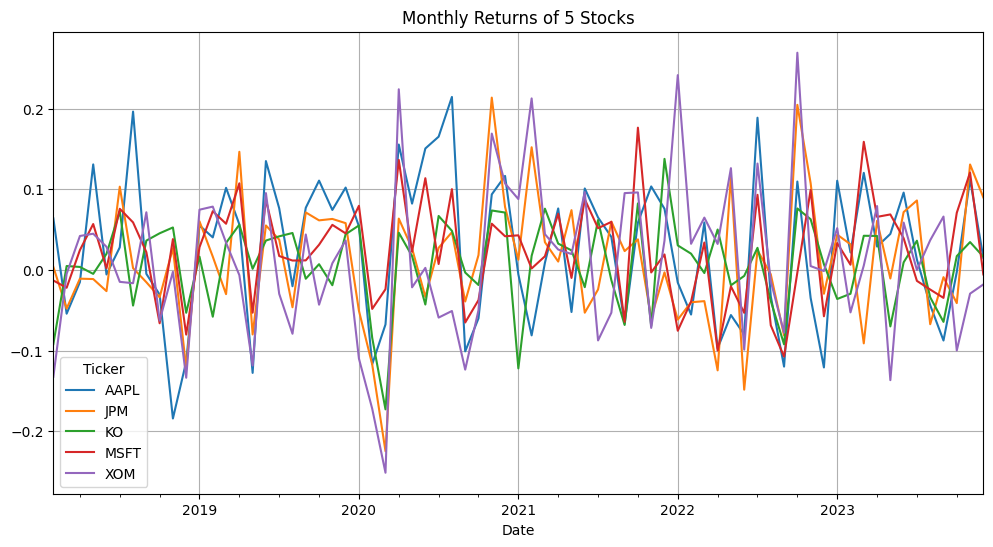

In [34]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# 5 representative stocks from different sectors
tickers = ['AAPL', 'JPM', 'XOM', 'KO', 'MSFT']
start_date = "2018-01-01"
end_date = "2023-12-31"

# Download monthly data
data = yf.download(tickers, start=start_date, end=end_date, interval='1mo', auto_adjust=True)
adj_close = data['Close'].dropna()

# Calculate monthly returns
monthly_returns = adj_close.pct_change().dropna()

# Plot the returns
monthly_returns.plot(figsize=(12, 6), title="Monthly Returns of 5 Stocks")
plt.grid(True)
plt.show()


In [35]:
import pandas as pd

# Step 2: Load Fama-French 3-Factor Data
file_path = "D:/quant-finance-45-day-sprint/data/F-F_Research_Data_Factors.CSV"
df = pd.read_csv(file_path, skiprows=3)

# Keep only rows where date is in YYYYMM format
df = df[df['Unnamed: 0'].str.match(r'^\d{6}$', na=False)].copy()

# Rename first column to 'Date'
df.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format="%Y%m")

# Select relevant columns and convert strings to numeric (force errors to NaN)
factor_cols = ['Mkt-RF', 'SMB', 'HML', 'RF']
for col in factor_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # converts bad strings to NaN

# Drop any rows with NaNs in factor columns
df.dropna(subset=factor_cols, inplace=True)

# Convert to decimal (from %)
df[factor_cols] = df[factor_cols] / 100

# Set index to Date
ff_factors = df[['Date'] + factor_cols].set_index('Date')

# Preview cleaned data
print(ff_factors.head())


            Mkt-RF     SMB     HML      RF
Date                                      
1926-07-01  0.0296 -0.0256 -0.0243  0.0022
1926-08-01  0.0264 -0.0117  0.0382  0.0025
1926-09-01  0.0036 -0.0140  0.0013  0.0023
1926-10-01 -0.0324 -0.0009  0.0070  0.0032
1926-11-01  0.0253 -0.0010 -0.0051  0.0031


In [36]:
# Step 3: Download 5-stock data and calculate monthly excess returns

import yfinance as yf

# Define tickers and date range
tickers = ['AAPL', 'JPM', 'XOM', 'KO', 'MSFT']
start_date = "2018-01-01"
end_date = "2023-12-31"

# Download monthly data
data = yf.download(tickers, start=start_date, end=end_date, interval='1mo', auto_adjust=True)

# Extract and clean adjusted close prices
adj_close = data['Close'].dropna()
monthly_returns = adj_close.pct_change().dropna()

# Align with Fama-French factor index
monthly_returns = monthly_returns[monthly_returns.index.isin(ff_factors.index)]

# Subtract RF to compute excess returns
rf_aligned = ff_factors['RF'].reindex(monthly_returns.index)
monthly_excess_returns = monthly_returns.sub(rf_aligned, axis=0)

# Join with factors
combined_data = monthly_excess_returns.join(ff_factors[['Mkt-RF', 'SMB', 'HML']], how='inner')

# Final check
print(combined_data.head())




[*********************100%***********************]  5 of 5 completed

                AAPL       JPM        KO      MSFT       XOM  Mkt-RF     SMB  \
Date                                                                           
2018-02-01  0.062747  0.002632 -0.092926 -0.014151 -0.133517 -0.0365  0.0023   
2018-03-01 -0.055310 -0.048979  0.003759 -0.023189 -0.005946 -0.0235  0.0405   
2018-04-01 -0.016420 -0.012221  0.002317  0.023252  0.040685  0.0028  0.0114   
2018-05-01  0.129364 -0.012683 -0.006260  0.055486  0.043488  0.0265  0.0526   
2018-06-01 -0.006999 -0.027659  0.018600  0.000597  0.027263  0.0048  0.0115   

               HML  
Date                
2018-02-01 -0.0107  
2018-03-01 -0.0023  
2018-04-01  0.0054  
2018-05-01 -0.0318  
2018-06-01 -0.0233  


In [37]:
import statsmodels.api as sm

capm_results = {}

for ticker in monthly_excess_returns.columns:
    # Merge factors and returns for the current ticker
    merged = pd.concat([monthly_excess_returns[ticker], ff_factors['Mkt-RF']], axis=1).dropna()
    merged.columns = ['Excess_Return', 'Mkt-RF']

    # Regression setup
    y = merged['Excess_Return']
    X = sm.add_constant(merged[['Mkt-RF']])

    # Fit model
    model = sm.OLS(y, X).fit()
    capm_results[ticker] = model

    print(f"\nCAPM Regression for {ticker}")
    print(model.summary())



CAPM Regression for AAPL
                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     56.29
Date:                Tue, 29 Jul 2025   Prob (F-statistic):           7.01e-10
Time:                        14:49:01   Log-Likelihood:                 73.421
No. Observations:                  55   AIC:                            -142.8
Df Residuals:                      53   BIC:                            -138.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190     

In [38]:
ff3_results = {}

for ticker in monthly_excess_returns.columns:
    merged = pd.concat([monthly_excess_returns[ticker], ff_factors[['Mkt-RF', 'SMB', 'HML']]], axis=1).dropna()
    merged.columns = ['Excess_Return', 'Mkt-RF', 'SMB', 'HML']

    y = merged['Excess_Return']
    X = sm.add_constant(merged[['Mkt-RF', 'SMB', 'HML']])

    model = sm.OLS(y, X).fit()
    ff3_results[ticker] = model

    print(f"\nFF3 Regression for {ticker}")
    print(model.summary())



FF3 Regression for AAPL
                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     24.23
Date:                Tue, 29 Jul 2025   Prob (F-statistic):           6.91e-10
Time:                        14:49:01   Log-Likelihood:                 77.886
No. Observations:                  55   AIC:                            -147.8
Df Residuals:                      51   BIC:                            -139.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0176      

## 📊 Summary of CAPM and Fama-French 3-Factor Regression Results (AAPL, JPM, KO, MSFT, XOM)

### 🔹 Key Takeaways:

1. **Market Sensitivity (Beta - `Mkt-RF`)**
   - All stocks show **significant positive exposure to market risk**, confirming they move with the overall market.
   - Highest CAPM Beta:
     - **AAPL (1.21)** → High sensitivity to market returns
     - **JPM (1.05), XOM (1.02)** → Above-average exposure
     - **MSFT (0.88)** → Lower beta than AAPL
     - **KO (0.50)** → Defensive, less market sensitive

2. **CAPM α (Intercept)**
   - **AAPL (0.019)** and **MSFT (0.014)** have **positive and statistically significant alpha**, indicating potential outperformance even after adjusting for market risk.
   - **JPM, KO, XOM** show insignificant alpha → no strong evidence of excess return under CAPM.

3. **R² Comparison (Model Fit)**
   - Best CAPM fit: **MSFT (R² = 0.64)**, **JPM (R² = 0.56)**, **AAPL (R² = 0.52)**
   - Weakest fit: **KO (0.24)** → CAPM explains little of KO’s returns.

---

### 🔹 Fama-French 3-Factor Model (FF3) Insights:

1. **Improved Model Fit (R²)**
   - **All stocks show improved R² with FF3** vs CAPM:
     - **MSFT (0.75), JPM (0.75), AAPL (0.59)** → Model better explains excess returns
     - **KO improves from 0.24 → 0.45**, XOM from 0.32 → 0.61

2. **Factor Sensitivities:**
   - **AAPL**:
     - Negatively exposed to **HML (-0.51)** → Growth stock
     - Slightly negative to **SMB (-0.44)** → Possibly a large-cap stock effect
   - **JPM**:
     - **Strong positive HML loading (0.74)** → Value stock characteristics
   - **KO**:
     - **Negative SMB (-0.78)** → Large-cap defensive
     - **Positive HML (0.31)** → Some value tilt
   - **MSFT**:
     - Similar to AAPL: **Growth exposure (HML = -0.41), negative SMB (-0.34)**
   - **XOM**:
     - **Positive HML (1.15)** → Strong value tilt
     - **Positive SMB (0.53)** → More exposed to small-cap premium

---

### ✅ Conclusion:

- **Tech stocks (AAPL, MSFT)** show growth orientation, strong market beta, and positive alpha.
- **JPM and XOM** align with value factors, with XOM especially sensitive to **HML**.
- **KO** is the most defensive, with weak CAPM fit but notable SMB/HML exposures under FF3.
- **Fama-French model explains more variance** than CAPM for all stocks, validating multi-factor use.

